### MNISTの画像を準備

* 特徴量をConvNetにする。randomでぼかした画像とgaussianでぼかした画像

In [1]:
from matplotlib import pyplot as plt
import torch as tc
from torch import nn
from torch import optim
from torch.nn import functional as F
import torchvision as tv
from torchvision import transforms
from torchvision import datasets as d
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from scipy.signal import fftconvolve

import random
from tqdm.notebook import tqdm
from collections import deque, namedtuple

from env import ReconstructionEnv
from view import view_moving_average
from test_result import test_policy

device = tc.device('cuda:0')

# pytorchからMNISTのデータをロード
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,))])
trainset = d.MNIST(root='./data', train=True, download=True, transform=transform)

testset = d.MNIST(root='./data', train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, shuffle=True)
testloader = DataLoader(testset, shuffle=False)

# ぼやけフィルタを用意
import numpy as np
from scipy.stats import multivariate_normal
from skimage.restoration import wiener

X, Y = np.meshgrid(np.arange(-2, 3, 1, dtype=np.float32), np.arange(-2, 3, 1, dtype=np.float32))
gauss_filters = []
std = 0.8
f = np.vectorize(
    lambda x, y: multivariate_normal([0.0, 0.0], np.diag([std]*2)).pdf([x, y])
)
gauss1 = f(X, Y)
gauss1 = gauss1 / gauss1.sum()
gauss1 = gauss1.astype(np.float32)

tc.random.manual_seed(0)
random1 = tc.rand((5, 5))
random1 = random1 / random1.sum()

# 復元フィルタを用意
ACTION_DIM = 4
actions = [
    lambda x: fftconvolve(x, gauss1, mode='same'),
    lambda x: fftconvolve(x, random1, mode='same'),
    lambda x: wiener(x, gauss1, 0.25),
    lambda x: wiener(x, random1, 0.016),
]
action_labels = ['gauss1', 'random1', 'wiener_of_gauss1', 'wiener_of_random1']
blur_filters = [gauss1, random1]

### 特徴量抽出器

In [2]:
import torch
class MnistNet(torch.nn.Module):
    def __init__(self, m=[20, 20]):
        super(MnistNet, self).__init__()
        self.m = m
        self.conv1 = torch.nn.Conv2d(1, self.m[0], 5, stride=1, padding=0)
        self.conv2 = torch.nn.Conv2d(self.m[0], self.m[1], 5, stride=1, padding=0)
        self.fc = torch.nn.Linear(4*4*self.m[1], 1)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, 2, 2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*self.m[1])
        x = self.fc(x)
        return x
    
    def encode(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, 2, 2)
        x = torch.nn.functional.relu(self.conv2(x))
        return x

conv_net = MnistNet(m=[5, 5])
conv_net.load_state_dict(tc.load('models/conv.pth'))
conv_net.to(device)

# test observe state
image, _ = next(iter(trainloader))
image = image.to(device)
with tc.no_grad():
    feature1 = conv_net.encode(image).squeeze(0)
    feature2 = conv_net.encode(image).squeeze(0)
    feature = tc.cat([feature1, feature2])
print('outer_state_shape', feature.unsqueeze(0).shape)

outer_state_shape torch.Size([1, 10, 8, 8])


In [3]:
# 環境の追加変更部分
T = 3

def blur_image(base, T):
    init_state = base.cpu().numpy()
    i = tc.randint(0, len(blur_filters), ())
    decay_kernel = blur_filters[i]
    for _ in range(T):
        init_state = fftconvolve(init_state, decay_kernel, mode='same')
    return init_state, i

# 最終的には、これがオートエンコーダーで特徴量抽出したものになる。
class OuterState(object):
    def __init__(self, inner_state):
        # Add chunnel
        with tc.no_grad():
            now = inner_state.now.unsqueeze(0).unsqueeze(0)
            now = conv_net.encode(now).squeeze(0)
            init = inner_state.init.unsqueeze(0).unsqueeze(0)
            init = conv_net.encode(init).squeeze(0)
        self.v = tc.cat([now, init])

In [4]:
# Agent
LAST_FILTER_WIDTH = 1
class ConvQualityFunction(nn.Module):
    def __init__(self, action_dim):
        super(ConvQualityFunction, self).__init__()
        self.conv1 = nn.Conv2d(10, 15, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(15, 20, 2)
        self.fc1 = nn.Linear(20*LAST_FILTER_WIDTH*LAST_FILTER_WIDTH, action_dim)
        self.dropout1 = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20*LAST_FILTER_WIDTH*LAST_FILTER_WIDTH)
        x = self.dropout1(x)
        return self.fc1(x)
    

class DQNAgent(object):
    def __init__(self, action_dim=ACTION_DIM, eps=0.1, lr=0.1, gamma=0.9):
        self.action_dim = action_dim
        self.eps = eps
        self.gamma = gamma
        self.Q_function = ConvQualityFunction(action_dim)
        self.Q_function.to(device)
        self.teacher_model = ConvQualityFunction(action_dim)
        self.teacher_model.to(device)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.RMSprop(self.Q_function.parameters(), lr=lr)
    
    def policy(self, state, train=False):
        if train and tc.rand(()) < self.eps:
            return tc.randint(self.action_dim, ())
        with tc.no_grad():
            action_qualities = self.Q_function(state.v.unsqueeze(0))
        return tc.argmax(action_qualities)

In [5]:
# Train TD法
Experience = namedtuple('Experience', ('s', 'a', 'ns', 'r', 'd'))

def update(agent, batch):
    # Experience Replayに基づいて行動評価関数のパラメーターを更新する。
    estimation_qualities = []
    true_qualities = []
    for i, e in enumerate(batch):
        est = agent.Q_function(e.s.v.unsqueeze(0)).squeeze(0)
        v = e.r
        if not e.d:
            with tc.no_grad():
                v += agent.gamma * tc.max(agent.teacher_model(e.ns.v.unsqueeze(0)).squeeze(0))
        estimation_qualities.append(est[e.a])
        true_qualities.append(v)
    estimation_qualities = tc.stack(estimation_qualities)
    true_qualities = tc.tensor(true_qualities).to(device)
    agent.optimizer.zero_grad()
    loss = agent.criterion(estimation_qualities, true_qualities)
    loss.backward()
    agent.optimizer.step()
    

def update_teacher(agent):
    agent.teacher_model.load_state_dict(agent.Q_function.state_dict())

    
def train(agent, seed=0, train_episode_num=10000, teacher_freq=3, n=100):
    experiences = deque(maxlen=1024)
    train_count = 0
    reward_records = []
    
    for _ in tqdm(range(train_episode_num)):
        Ri = 0
        env = ReconstructionEnv(
            trainloader=trainloader,
            testloader=testloader,
            OuterStateClass=OuterState,
            actions=actions,
            T=T,
            blur_func=blur_image
        )
        env.reset()
        done = False
        while not done:
            action = agent.policy(env.state, train=True)
            next_state, reward, done = env.step(action)
            e = Experience(env.state, action, next_state, reward, done)
            experiences.append(e)
            Ri += reward
            
        if len(experiences) == 1024:
            batch = random.sample(experiences, 32)
            # update by 勾配TD学習
            update(agent, batch)
            train_count += 1
        
        if train_count % teacher_freq == 0:
            # Target Networkを今の行動価値関数で更新
            update_teacher(agent)
        
        reward_records.append(Ri)
    
    return reward_records

In [ ]:
train_conds = {
    'seed': 100,
    'trep': 40000,
    'n': 1000,
    'eps': 0.3,
    'lr': 0.01
}
random.seed(train_conds['seed'])
tc.random.manual_seed(train_conds['seed'])
agent = DQNAgent(eps=train_conds['eps'], lr=train_conds['lr'])
rewards = train(agent, train_episode_num=train_conds['trep'], n=train_conds['n'])
view_moving_average(tc.tensor(rewards), n=train_conds['n'])

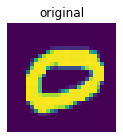

1 回での random1 での復元
loss of step(1) 7.71467399597168//
reward_sum:  -7.71467399597168


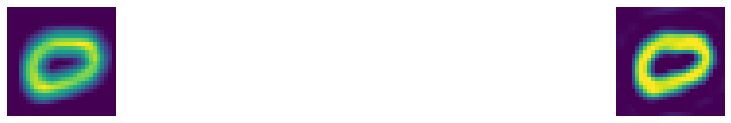

['wiener_of_random1']


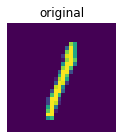

1 回での gauss1 での復元
loss of step(1) 15.24785041809082//
reward_sum:  -15.24785041809082


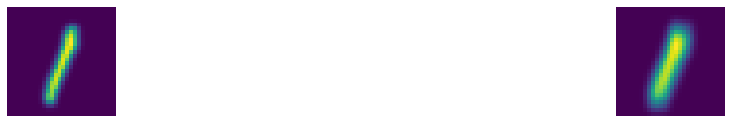

['random1']


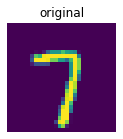

1 回での random1 での復元
loss of step(1) 5.821706295013428//
reward_sum:  -5.821706295013428


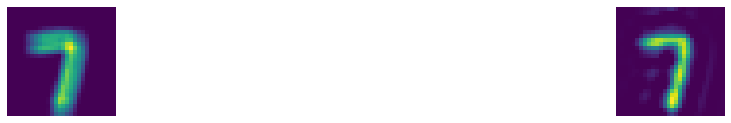

['wiener_of_random1']


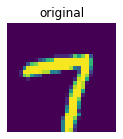

1 回での gauss1 での復元
loss of step(1) 23.030895233154297//
reward_sum:  -23.030895233154297


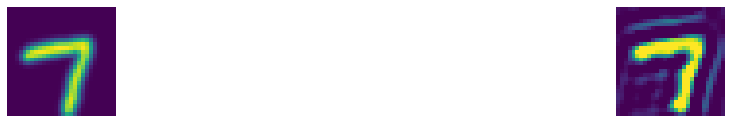

['wiener_of_random1']


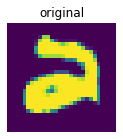

1 回での random1 での復元
loss of step(1) 40.08551025390625//
reward_sum:  -40.08551025390625


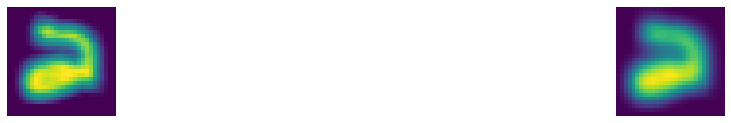

['random1']


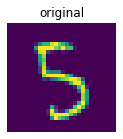

1 回での random1 での復元
loss of step(1) 9.801774978637695//
reward_sum:  -9.801774978637695


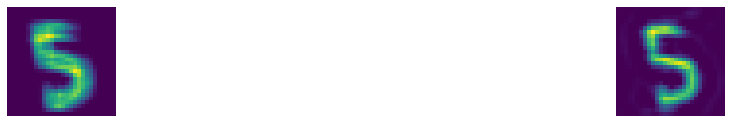

['wiener_of_random1']


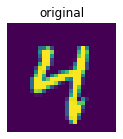

1 回での random1 での復元
loss of step(1) 34.11964416503906//
reward_sum:  -34.11964416503906


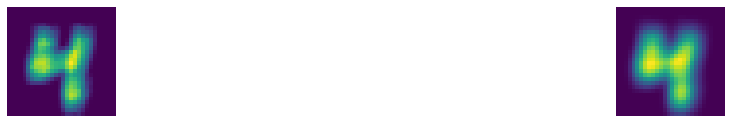

['random1']


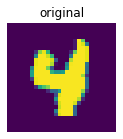

1 回での gauss1 での復元
loss of step(1) 14.65289306640625//
reward_sum:  -14.65289306640625


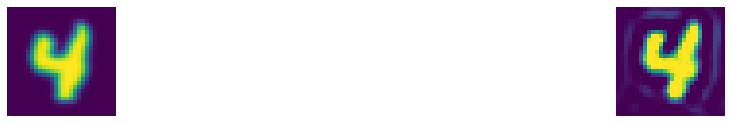

['wiener_of_random1']


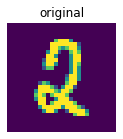

1 回での random1 での復元
loss of step(1) 13.076946258544922//
reward_sum:  -13.076946258544922


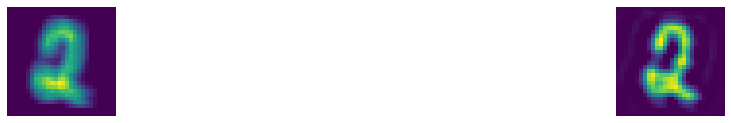

['wiener_of_random1']


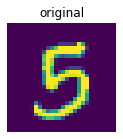

1 回での gauss1 での復元
loss of step(1) 35.05941390991211//
reward_sum:  -35.05941390991211


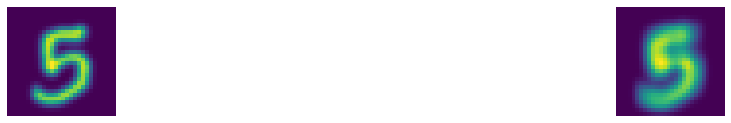

['random1']


In [8]:
for i in range(10):
    env = ReconstructionEnv(
        trainloader=trainloader,
        testloader=testloader,
        OuterStateClass=OuterState,
        actions=actions,
        T=T,
        blur_func=blur_image
    )
    env.reset()
    test_policy(env, action_labels, T, agent)

In [ ]:
# スコアの平均値を比較しておく
tc.random.manual_seed(0)

def random_one_try(action_dim):
    env = ReconstructionEnv(OuterState, train=False)
    env.reset()
    done = False
    reward_sum = 0
    while not done:
        a = tc.randint(0, action_dim + 1, ())
        _, reward, done = env.step(a)
        reward_sum += reward
    return reward_sum

def proper_inverse_filter_one_try():
    env = ReconstructionEnv(OuterState, train=False)
    env.reset()
    done = False
    reward_sum = 0
    while not done:
        a = 2 if env.decay_kernel_index == 0 else 3
        _, reward, done = env.step(a)
        reward_sum += reward
    return reward_sum

def upside_down():
    env = ReconstructionEnv(OuterState, train=False)
    env.reset()
    done = False
    reward_sum = 0
    while not done:
        a = 3 if env.decay_kernel_index == 0 else 2
        _, reward, done = env.step(a)
        reward_sum += reward
    return reward_sum

def agent_one_try(agent):
    env = ReconstructionEnv(OuterState, train=False)
    env.reset()
    done = False
    reward_sum = 0
    while not done:
        a = agent.policy(env.state)
        _, reward, done = env.step(a)
        reward_sum += reward
    return reward_sum

sum_info = {'random': 0, 'proper': 0, 'upside_down': 0, 'agent': 0}
n = 1000
for _ in tqdm(range(n)):
    sum_info['random'] += random_one_try(agent.action_dim)
    sum_info['proper'] += proper_inverse_filter_one_try()
    sum_info['upside_down'] += upside_down()
    sum_info['agent'] += agent_one_try(agent)

for key, val in sum_info.items():
    print(key, f'{val / n:.2f}')

### それぞれのフィルタの報酬の総和をみておく

In [8]:
# proper
print('proper')
env = ReconstructionEnv(OuterState)
env.reset()
a = 2 if env.decay_kernel_index == 0 else 3
test_policy(env, action_labels, fixed_action=a)
print()

# gauss1, gauss2
for i in range(2):
    print(action_labels[i])
    env = ReconstructionEnv(OuterState)
    env.reset()
    test_policy(env, fixed_action=i)
    print()

proper


TypeError: __init__() missing 4 required positional arguments: 'testloader', 'OuterStateClass', 'T', and 'blur_filters'